In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib

# Data loading & pre-processing

In [114]:
from arff2pandas import a2p

def load(file):
    df = pd.read_csv(file)
    return df

def impute_missing_values(df):
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(missing_values=np.NaN)
    idf = pd.DataFrame(imp.fit_transform(df))
    idf.columns = df.columns
    idf.index = df.index
    return idf

In [115]:
df = load('spambase/spambase.data')
df = impute_missing_values(df) # fill missing values
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_bracket,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0,1.0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0,1.0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0,1.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0,1.0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3.0,88.0,0.0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4.0,14.0,0.0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6.0,118.0,0.0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5.0,78.0,0.0


In [41]:
def split_df(df):
    from sklearn.model_selection import train_test_split
    df = impute_missing_values(df)
    
    X = df[df.columns[:-1]]
    Y = df[df.columns[-1]]
    return train_test_split(X,Y)

# Data Analysis

In [93]:
df.groupby("spam").size().reset_index(name='counts')

,spam,counts
0,0,2788
1,1,1813


There are 2788 non-spam emails and 1813 spam emails in the dataset.

This dataset is composed of statictics about 4600 mails' content.

For 60 words/caracters, it gives their frequency over the total words/caracters.

The 3 last variables gives information on capitals letters in the mail.

Our goal is to predict if a mail is a spam based on these statistics.

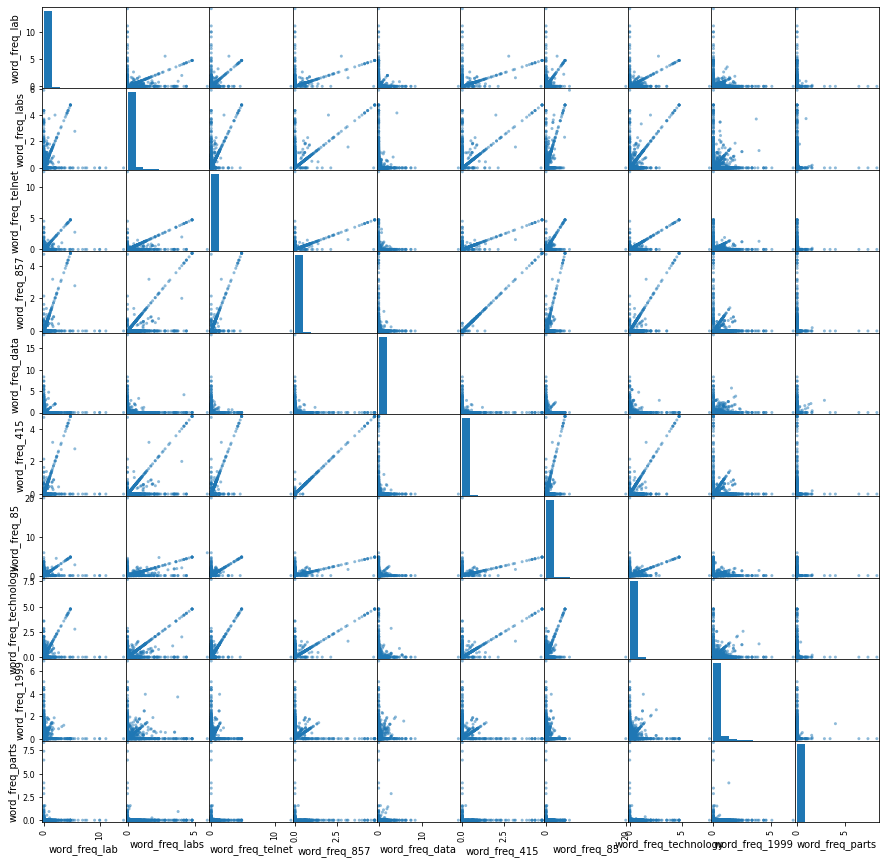

In [17]:
scatter_mat = pd.plotting.scatter_matrix(df[df.columns[-30:-20]], figsize=(15,15))

Due to the huge number of variables, we can't print a full scatter matrix. However, on a reduced number of variables we can clearly see some correlation.

<AxesSubplot:>

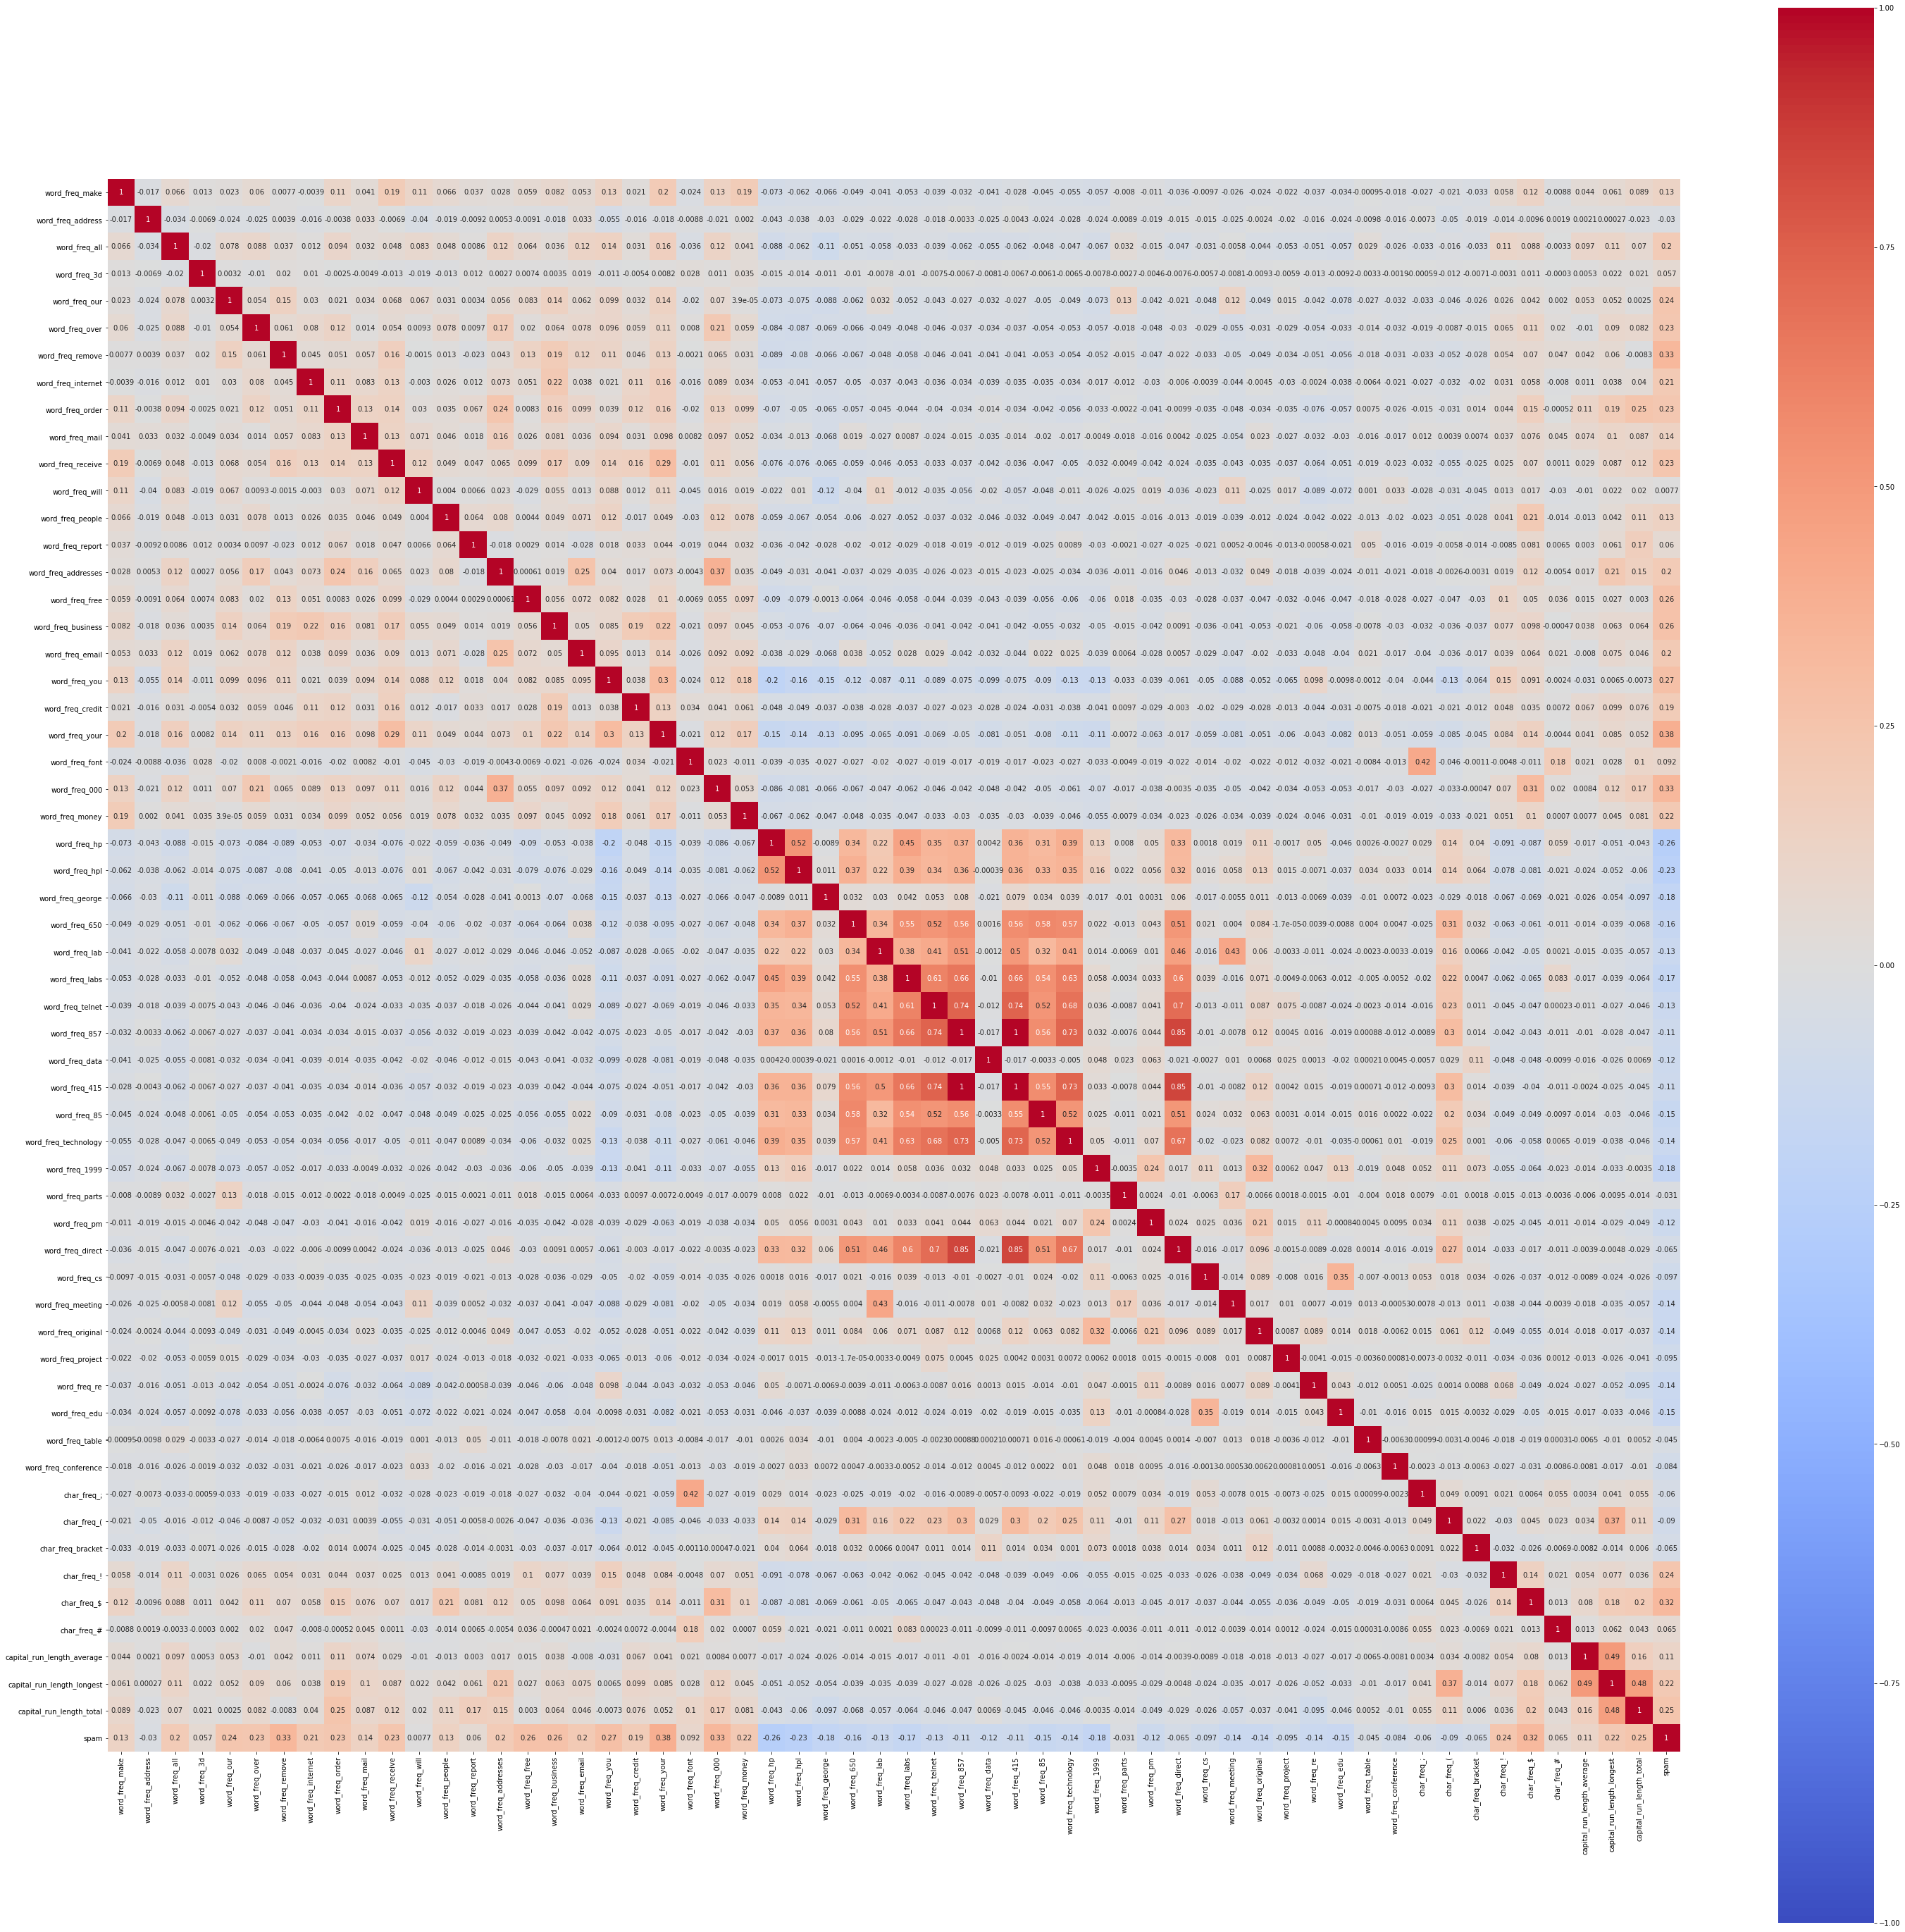

In [20]:
plt.figure(figsize=(50,50))
sns.heatmap(df.corr("pearson"), bvmin=-1, vmax=1, cmap='coolwarm', annot=True, square=True)

We can see that the frequency of some group of words are correlated but not to every variable so we can't remove them. Similarly, the variables about the capitals seem slightly correlated.

In [153]:
df.groupby('spam')[df.columns[-2]].describe(percentiles=[0.5, 0.2])

,count,mean,std,min,20%,50%,max
spam,,,,,,,
0.0,2788.0,161.470947,355.738403,1.0,14.0,54.0,5902.0
1.0,1813.0,470.619415,825.081179,2.0,78.0,194.0,15841.0


In average, a non-spam email has 161 capitals whereas a spam email has 470 capitals.

Moreover, 80% of spam emails have more than 78 capitals versus 14 for non-spam emails.

In conclusion, capital letters gives a good information but is not enough to classify emails : we need the other variables.

# Looking for the best model
## Random Forest Classifier

In [91]:
def confusion_mat(model, x_test, y_test):
    from sklearn.metrics import confusion_matrix
    
    predictions = model.predict(x_test)
    return confusion_matrix(y_test, predictions)
    
def grid_search(df, classifier, parameters):
    from sklearn.model_selection import RandomizedSearchCV
    
    x_train, x_test, y_train, y_test = split_df(df)
    
    grid = RandomizedSearchCV(classifier, parameters)
    
    try: grid.fit(x_train, y_train)
    except Exception as e : print(e)
    
    print("Best score: " + str(grid.best_estimator_.score(x_test, y_test)))
    print("Confusion matrix:")
    print(confusion_mat(grid.best_estimator_, x_test, y_test))
    
    return grid.best_estimator_


In [116]:
from sklearn.ensemble import RandomForestClassifier
parameters = { 
    'n_estimators': [5, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

random_forest_model = grid_search(df, RandomForestClassifier(), parameters)
_ = joblib.dump(random_forest_model, 'api/randomforest.pkl', compress=9)

Best score: 0.9348392701998263
Confusion matrix:
[[666  24]
 [ 51 410]]


## Logistic regression

In [128]:
def logistic_reg(df):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import classification_report

    x_train, x_test, y_train, y_test = split_df(df)
    
    logistic_regression = LogisticRegression()
    logistic_regression.fit(x_train, y_train)
    logistic_prediction = logistic_regression.predict(x_test)
    
    print("Score: " + str(logistic_regression.score(x_test, y_test)))
    print(confusion_mat(logistic_regression, x_test, y_test))
    
logistic_reg(df)

Score: 0.9235447437011295
[[641  34]
 [ 54 422]]


/usr/local/Cellar/jupyterlab/3.0.0_1/libexec/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## XGB Classifier

In [141]:
def xgb(df):
    from xgboost import XGBClassifier
    
    x_train, x_test, y_train, y_test = split_df(df)
    
    algo   = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    modele = algo.fit(x_train, y_train)
    print(modele.score(x_test, y_test))
    print(confusion_mat(modele, x_test, y_test))
    return modele

modele = xgb(df)
_ = joblib.dump(modele, 'api/xgb.pkl', compress=9)

0.9548218940052129
[[672  25]
 [ 27 427]]


## Catboost Classifier

In [142]:
def catboost(df):
    from catboost import CatBoostClassifier
    
    x_train, x_test, y_train, y_test = split_df(df)
    
    algo   = CatBoostClassifier(verbose = False)
    model = algo.fit(x_train, y_train)
    print(model.score(x_test, y_test))
    print(confusion_mat(model, x_test, y_test))
    return model

model = catboost(df)

_ = joblib.dump(model, 'api/catboost.pkl', compress=9)

0.9609035621198957
[[699  20]
 [ 25 407]]


Catboost Classifier looks like the best model with 0.96 score.